In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le jeu de données
data = pd.read_csv("data/revenus.csv")

In [67]:
# Première itération
# Remplacer les '?' par NaN pour un traitement plus facile des valeurs manquantes
data.replace('?', pd.NA, inplace=True)

# Étape 1: Encodage des variables catégorielles
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'gender', 'native-country', 'income']
label_encoders = {}

# Encoder chaque colonne catégorielle
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col].astype(str))

# Vérification et suppression de la colonne 'fnlwgt' si elle existe
if 'fnlwgt' in data.columns:
    data.drop(columns=['fnlwgt'], inplace=True)

# Exclure 'capital-gain' et 'capital-loss' des variables pour la détection d'anomalies
X_for_outlier_detection = data.drop(columns=['capital-gain', 'capital-loss', 'income'])

# Isolation Forest pour détecter les valeurs aberrantes
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X_for_outlier_detection)

# Ajouter une colonne pour indiquer les valeurs aberrantes
data['outlier'] = outliers

# Afficher les premières lignes des données après avoir marqué les valeurs aberrantes
print("\nDonnées après Isolation Forest (1 = non-aberrant, -1 = aberrant) :")
print(data[['age', 'workclass', 'capital-gain', 'capital-loss', 'outlier']].head())

# Garder uniquement les points qui ne sont pas des anomalies
data_cleaned = data[data['outlier'] == 1].drop(columns=['outlier'])

# Afficher les premières lignes des données après suppression des valeurs aberrantes
print("\nDonnées après suppression des valeurs aberrantes :")
print(data_cleaned[['age', 'workclass', 'capital-gain', 'capital-loss']].head())


Données après Isolation Forest (1 = non-aberrant, -1 = aberrant) :
   age  workclass  capital-gain  capital-loss  outlier
0   25          4             0             0        1
1   38          4             0             0        1
2   28          2             0             0        1
3   44          4          7688             0        1
4   18          0             0             0        1

Données après suppression des valeurs aberrantes :
   age  workclass  capital-gain  capital-loss
0   25          4             0             0
1   38          4             0             0
2   28          2             0             0
3   44          4          7688             0
4   18          0             0             0


In [63]:
# Étape 2: Normalisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


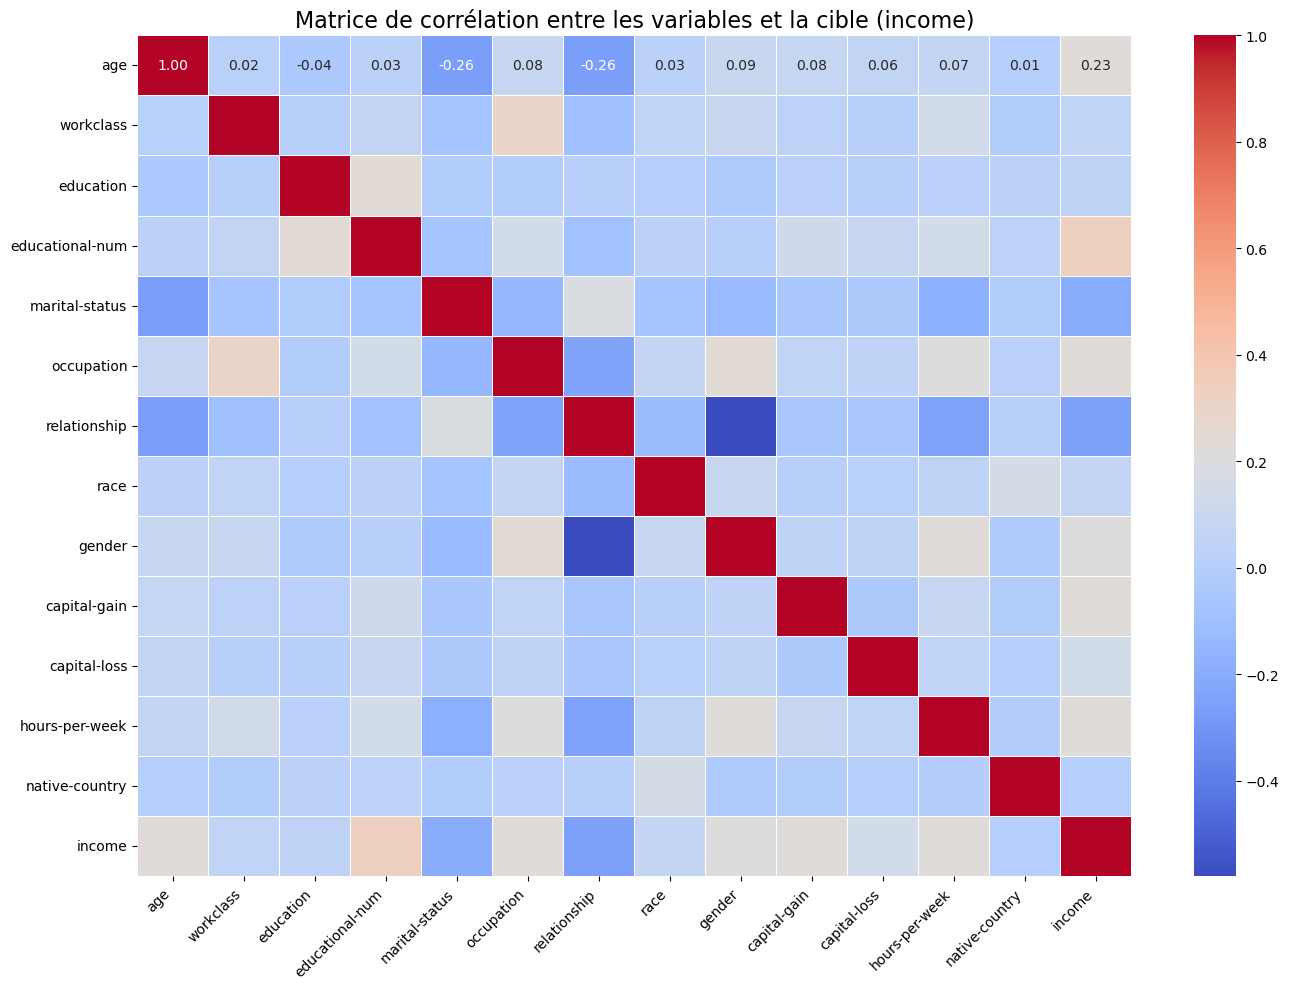

In [65]:
# Étape 3: Imputation des valeurs manquantes par KNN
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(scaled_data)

# Convertir les données imputées en DataFrame
imputed_data = pd.DataFrame(imputed_data, columns=data.columns)



# Récupérer la variable cible (income) sous sa forme originale encodée en 0 et 1
y = data['income']  # Réutiliser la variable d'origine (non normalisée)

# Diviser les données en variables explicatives et cible
X = imputed_data.drop(columns=['income'])

# ### Présentation des corrélations ###
# Ajouter la colonne income au DataFrame des variables pour calculer les corrélations
correlation_matrix = pd.concat([X, y], axis=1).corr()

# Visualisation des corrélations
plt.figure(figsize=(14, 10))  # Augmenter la taille de la figure pour plus de clarté
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 10})
plt.title("Matrice de corrélation entre les variables et la cible (income)", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour une meilleure lisibilité
plt.yticks(rotation=0)
plt.tight_layout()  # Ajuster automatiquement les marges
plt.show()

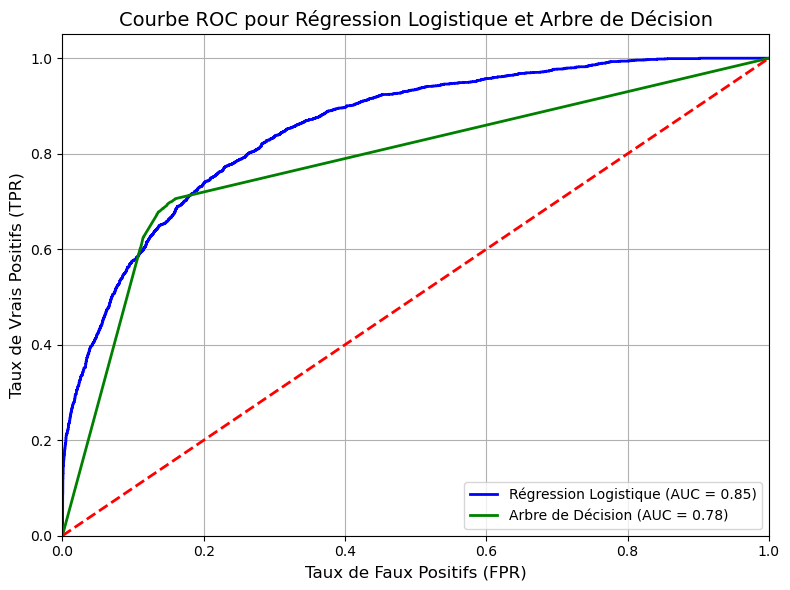


Régression Logistique :
Accuracy: 0.8271
F1-Score: 0.5492
AUC: 0.8546

Arbre de Décision :
Accuracy: 0.8242
F1-Score: 0.6260
AUC: 0.7829


In [49]:
# Étape 4: Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement des modèles
# Modèle de régression logistique
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Modèle d'arbre de décision
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Prédictions
y_pred_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]  # Probabilité que la classe soit 1
y_pred_prob_tree = decision_tree.predict_proba(X_test)[:, 1]

# Calcul des courbes ROC
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_prob_log_reg)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_prob_tree)

# Calcul des AUC
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'Régression Logistique (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_tree, tpr_tree, color='green', lw=2, label=f'Arbre de Décision (AUC = {roc_auc_tree:.2f})')

# Ajout de la diagonale
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)

# Paramètres de la courbe
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbe ROC pour Régression Logistique et Arbre de Décision', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Affichage des résultats
log_reg_metrics = {
    "Accuracy": accuracy_score(y_test, log_reg.predict(X_test)),
    "F1-Score": f1_score(y_test, log_reg.predict(X_test)),
    "AUC": roc_auc_log_reg
}

tree_metrics = {
    "Accuracy": accuracy_score(y_test, decision_tree.predict(X_test)),
    "F1-Score": f1_score(y_test, decision_tree.predict(X_test)),
    "AUC": roc_auc_tree
}

print("\nRégression Logistique :")
for metric, value in log_reg_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nArbre de Décision :")
for metric, value in tree_metrics.items():
    print(f"{metric}: {value:.4f}")